# Machine Learning Practices - Project (CS2008p)


---

## About the Project

This notebook presents my work for the **CS2008p (Machine Learning Practices Project)** as part of the BS in Data Science and Applications program.

- **Objective:**  
  Predict a customer's total **purchase value** using multi-session behavioral and contextual data.
- **Approach:**  
  Use features including session activity logs, device/browser types, traffic sources, and geographic data to train regression models estimating purchase value.

**Competition Link:**  
[Kaggle Challenge](https://www.kaggle.com/t/f36be8a7aee7492683e5b709ab8082eb)

---

## About Me

| Info         | Description                                |
|--------------|--------------------------------------------|
| Name         | Sumit Kumar                                |
| Roll Number  | 22f3002869                                 |
| Course Code  | CS2008p                                    |
| Email        | [22f3002869@ds.study.iitm.ac.in](mailto:22f3002869@ds.study.iitm.ac.in) |

---

## Workflow Overview

1. **Problem understanding and dataset review**
2. **Data loading & initial exploration**
3. **Cleaning & preprocessing**
4. **Exploratory Data Analysis (EDA)**
5. **Feature engineering & selection**
6. **Model selection & training**
7. **Model evaluation (e.g., R² score)**
8. **Prediction on test data & submission file creation**
9. **Interpretation and inference**

---

## Data Information

- **Task Type:** Regression—predict continuous target variable `purchaseValue`.
- **Features:**
  - Session details (hits, page views, session number)
  - Device and browser information
  - Traffic source data
  - Geographic context (continent, city, region)
- **Files Provided:**
  - `train_data.csv`: Training data with target
  - `test_data.csv`: Test data for final predictions
  - `sample_submission.csv`: Format for competition submission
- **Metric:**  
  R² (coefficient of determination)—measures variance explained by model

---

## Notes

- Documentation and best practices are followed for reproducibility.
- Random seeds, software/library versions, and model choices are clearly stated in the notebook.
- This README is updated as the project progresses through milestones.

---

## Contact

Questions or collaborations:  
[22f3002869@ds.study.iitm.ac.in](mailto:22f3002869@ds.study.iitm.ac.in)

---


## 1. Library Imports & Environment Setup

Below, we import key libraries and configure paths for both Kaggle and local execution. We’ll also display the first and last few rows (head and tail) of every imported dataset for quick inspection.


In [1]:

import os, warnings, math, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)

if os.path.exists("/kaggle/input"):
    BASE = "/kaggle/input/Cinema_Audience_Forecasting_challenge"  
    PATHS = {
        "book_visits":     os.path.join(BASE, "booknow_visits", "booknow_visits.csv"),
        "book_booking":    os.path.join(BASE, "booknow_booking", "booknow_booking.csv"),
        "cine_booking":    os.path.join(BASE, "cinePOS_booking", "cinePOS_booking.csv"),
        "book_theaters":   os.path.join(BASE, "booknow_theaters", "booknow_theaters.csv"),
        "cine_theaters":   os.path.join(BASE, "cinePOS_theaters", "cinePOS_theaters.csv"),
        "relation":        os.path.join(BASE, "movie_theater_id_relation", "movie_theater_id_relation.csv"),
        "date_info":       os.path.join(BASE, "date_info", "date_info.csv"),
        "sample_submission": os.path.join(BASE, "sample_submission", "sample_submission.csv"),
    }
else:
    BASE = r"C:\Users\ASUS\Downloads\MLP Project Try 2\Cinema_Audience_Forecasting_challenge"
    PATHS = {
        "book_visits":     os.path.join(BASE, "booknow_visits.csv"),
        "book_booking":    os.path.join(BASE, "booknow_booking.csv"),
        "cine_booking":    os.path.join(BASE, "cinePOS_booking.csv"),
        "book_theaters":   os.path.join(BASE, "booknow_theaters.csv"),
        "cine_theaters":   os.path.join(BASE, "cinePOS_theaters.csv"),
        "relation":        os.path.join(BASE, "movie_theater_id_relation.csv"),
        "date_info":       os.path.join(BASE, "date_info.csv"),
        "sample_submission": os.path.join(BASE, "sample_submission.csv"),
    }

# print("BASE path:", BASE)
# for k,v in PATHS.items():
#     print(k, "->", v)




## 2. Data Loading and Initial Inspection

Read all datasets into Pandas DataFrames, print each dataset’s shape, column names, and preview first & last rows for a fast, thorough sanity check.


In [2]:
# Load data
# print("\nLoading CSVs (may take a few seconds)...")
book_visits = pd.read_csv(PATHS["book_visits"], parse_dates=["show_date"])
book_booking = pd.read_csv(PATHS["book_booking"], parse_dates=["show_datetime","booking_datetime"])
cine_booking = pd.read_csv(PATHS["cine_booking"], parse_dates=["show_datetime","booking_datetime"])
book_theaters = pd.read_csv(PATHS["book_theaters"])
cine_theaters = pd.read_csv(PATHS["cine_theaters"])
relation = pd.read_csv(PATHS["relation"])
date_info = pd.read_csv(PATHS["date_info"], parse_dates=["show_date"])
sample_sub = pd.read_csv(PATHS["sample_submission"])

# print(" Data loaded")
print("\nShapes:")
for name,df in [("book_visits",book_visits),("book_booking",book_booking),("cine_booking",cine_booking),
                ("book_theaters",book_theaters),("cine_theaters",cine_theaters),
                ("relation",relation),("date_info",date_info),("sample_submission",sample_sub)]:
    print(f" {name}: {df.shape}")

# small sanity peek
print("\nbook_visits columns:", book_visits.columns.tolist())
print("date_info columns:", date_info.columns.tolist())


# Quick cleaning & prep
book_visits.columns = book_visits.columns.str.strip()
book_booking.columns = book_booking.columns.str.strip()
cine_booking.columns = cine_booking.columns.str.strip()
book_theaters.columns = book_theaters.columns.str.strip()
cine_theaters.columns = cine_theaters.columns.str.strip()
relation.columns = relation.columns.str.strip()
date_info.columns = date_info.columns.str.strip()
sample_sub.columns = sample_sub.columns.str.strip()

book_visits["show_date"] = pd.to_datetime(book_visits["show_date"])



Shapes:
 book_visits: (214046, 3)
 book_booking: (68336, 4)
 cine_booking: (1641966, 4)
 book_theaters: (829, 5)
 cine_theaters: (4690, 5)
 relation: (150, 2)
 date_info: (547, 2)
 sample_submission: (38062, 2)

book_visits columns: ['book_theater_id', 'show_date', 'audience_count']
date_info columns: ['show_date', 'day_of_week']


In [3]:
def print_column_types(df, name="DataFrame"):
    print(f"\n=== {name}: column types ===")
    for col in df.columns:
        print(f"{col:30s} -> {df[col].dtype}")

    print("\nSummary:")
    print("Numeric columns:")
    print(df.select_dtypes(include=["int64", "float64"]).columns.tolist())
    print("\nCategorical / object columns:")
    print(df.select_dtypes(include=["object"]).columns.tolist())
    print("\nDatetime columns:")
    print(df.select_dtypes(include=["datetime64[ns]"]).columns.tolist())

# example usage:
print_column_types(book_visits, "book_visits")
print_column_types(book_booking, "book_booking")
print_column_types(cine_booking, "cine_booking")
print_column_types(book_theaters, "book_theaters")
print_column_types(cine_theaters, "cine_theaters")
print_column_types(relation, "relation")
print_column_types(date_info, "date_info")



=== book_visits: column types ===
book_theater_id                -> object
show_date                      -> datetime64[ns]
audience_count                 -> int64

Summary:
Numeric columns:
['audience_count']

Categorical / object columns:
['book_theater_id']

Datetime columns:
['show_date']

=== book_booking: column types ===
book_theater_id                -> object
show_datetime                  -> datetime64[ns]
booking_datetime               -> datetime64[ns]
tickets_booked                 -> int64

Summary:
Numeric columns:
['tickets_booked']

Categorical / object columns:
['book_theater_id']

Datetime columns:
['show_datetime', 'booking_datetime']

=== cine_booking: column types ===
cine_theater_id                -> object
show_datetime                  -> datetime64[ns]
booking_datetime               -> datetime64[ns]
tickets_sold                   -> int64

Summary:
Numeric columns:
['tickets_sold']

Categorical / object columns:
['cine_theater_id']

Datetime columns:
['show_

In [4]:
# Helper: Print shape, columns, head/tail for each data table
dataframes = [
    ("book_visits", book_visits),
    ("book_booking", book_booking),
    ("cine_booking", cine_booking),
    ("book_theaters", book_theaters),
    ("cine_theaters", cine_theaters),
    ("relation", relation),
    ("date_info", date_info),
    ("sample_submission", sample_sub)
]

for name, df in dataframes:
    print(f"\n=== {name} ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("Head:")
    display(df.head())
    print("Tail:")
    display(df.tail())



=== book_visits ===
Shape: (214046, 3)
Columns: ['book_theater_id', 'show_date', 'audience_count']
Head:


,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


Tail:


,book_theater_id,show_date,audience_count
214041,book_00829,2024-02-23,16
214042,book_00829,2024-02-24,8
214043,book_00829,2024-02-25,16
214044,book_00829,2024-02-27,16
214045,book_00829,2024-02-28,16



=== book_booking ===
Shape: (68336, 4)
Columns: ['book_theater_id', 'show_datetime', 'booking_datetime', 'tickets_booked']
Head:


,book_theater_id,show_datetime,booking_datetime,tickets_booked
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6
3,book_00244,2023-01-01 20:00:00,2023-01-01 16:00:00,2
4,book_00151,2023-01-01 20:00:00,2023-01-01 01:00:00,5


Tail:


,book_theater_id,show_datetime,booking_datetime,tickets_booked
68331,book_00523,2024-02-28 23:00:00,2024-02-27 19:00:00,7
68332,book_00073,2024-02-28 23:00:00,2024-02-19 07:00:00,6
68333,book_00456,2024-02-28 23:00:00,2024-02-28 22:00:00,2
68334,book_00388,2024-02-28 23:00:00,2024-02-23 16:00:00,8
68335,book_00388,2024-02-28 23:00:00,2024-02-15 23:00:00,8



=== cine_booking ===
Shape: (1641966, 4)
Columns: ['cine_theater_id', 'show_datetime', 'booking_datetime', 'tickets_sold']
Head:


,cine_theater_id,show_datetime,booking_datetime,tickets_sold
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2
3,cinePOS_00004,2023-01-01 17:00:00,2023-01-01 11:00:00,5
4,cinePOS_00005,2023-01-01 17:00:00,2023-01-01 03:00:00,13


Tail:


,cine_theater_id,show_datetime,booking_datetime,tickets_sold
1641961,cinePOS_02502,2024-02-28 23:00:00,2024-02-28 09:00:00,2
1641962,cinePOS_12483,2024-02-28 23:00:00,2024-02-24 16:00:00,7
1641963,cinePOS_00334,2024-02-28 23:00:00,2024-01-26 18:00:00,1
1641964,cinePOS_06176,2024-02-28 23:00:00,2024-02-21 00:00:00,11
1641965,cinePOS_05713,2024-02-28 23:00:00,2024-02-22 19:00:00,2



=== book_theaters ===
Shape: (829, 5)
Columns: ['book_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']
Head:


,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515


Tail:


,book_theater_id,theater_type,theater_area,latitude,longitude
824,NaN,Drama,Area_006,23.005894,79.915496
825,NaN,Action,Area_006,23.005894,79.915496
826,book_00305,Action,Area_006,23.005894,79.915496
827,book_00216,Comedy,Area_016,25.963367,80.570258
828,NaN,Comedy,Area_016,25.963367,80.570258



=== cine_theaters ===
Shape: (4690, 5)
Columns: ['cine_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']
Head:


,cine_theater_id,theater_type,theater_area,latitude,longitude
0,cinePOS_05466,Other,Area_104,22.619233,78.113017
1,cinePOS_08708,Other,Area_104,22.619233,78.113017
2,cinePOS_00753,Other,Area_104,22.619233,78.113017
3,cinePOS_05776,Other,Area_104,22.619233,78.113017
4,cinePOS_07536,Other,Area_104,23.004410,79.934515


Tail:


,cine_theater_id,theater_type,theater_area,latitude,longitude
4685,cinePOS_08203,Other,Area_131,NaN,NaN
4686,cinePOS_04068,Other,Area_100,NaN,NaN
4687,cinePOS_03885,Other,Area_131,NaN,NaN
4688,cinePOS_04204,Other,Area_133,NaN,NaN
4689,cinePOS_00501,Other,Area_145,NaN,NaN



=== relation ===
Shape: (150, 2)
Columns: ['book_theater_id', 'cine_theater_id']
Head:


,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923
3,book_00094,cinePOS_02479
4,book_00052,cinePOS_06750


Tail:


,book_theater_id,cine_theater_id
145,book_00363,cinePOS_09012
146,book_00042,cinePOS_02789
147,book_00746,cinePOS_09057
148,book_00625,cinePOS_05648
149,book_00222,cinePOS_06697



=== date_info ===
Shape: (547, 2)
Columns: ['show_date', 'day_of_week']
Head:


,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday
3,2023-01-04,Wednesday
4,2023-01-05,Thursday


Tail:


,show_date,day_of_week
542,2024-06-26,Wednesday
543,2024-06-27,Thursday
544,2024-06-28,Friday
545,2024-06-29,Saturday
546,2024-06-30,Sunday



=== sample_submission ===
Shape: (38062, 2)
Columns: ['ID', 'audience_count']
Head:


,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0


Tail:


,ID,audience_count
38057,book_00829_2024-04-18,0
38058,book_00829_2024-04-19,0
38059,book_00829_2024-04-20,0
38060,book_00829_2024-04-21,0
38061,book_00829_2024-04-22,0


# 3. Exploratory Data Analysis (EDA)

This section explores the main audience patterns, outliers, seasonality, booking statistics, and correlation insights in the cinema show and ticket sales datasets. Multiple visualizations and statistical summaries are used for interpretability and to inform feature engineering.

---

## 3.1 Target Variable Statistics
- Display basic stats for the `audience_count` target: mean, std, min, max, quantiles.
- Calculate **skewness** and **kurtosis** to check symmetry and tail heaviness.

## 3.2 Audience Count Distribution
- Plot histogram of `audience_count` for both linear and log1p-transformed values.
- Reveals strong right skew and presence of outliers.

## 3.3 Stationarity Check
- Aggregate daily audience counts and run Augmented Dickey-Fuller (ADF) test.
- Determines whether the time series is stationary (does not trend over time).

## 3.4 Rolling Means & Trend Visualization
- Plot total daily audience alongside 7-day and 30-day rolling means.
- Visualizes seasonality and smoothing of audience trends.

## 3.5 Weekly & Monthly Pattern Analysis
- Bar plots showing average audience by weekday (`dayofweek`).
- Bar plots for average by calendar month, revealing seasonal peaks/troughs.

## 3.6 Boxplot of Audience Count
- Boxplot to visualize and detect outliers in audience counts.

## 3.7 Missing Data Heatmaps
- Heatmap visualization of 200 random rows each from `booknow_booking` and `cinePOS_booking`.
- Highlights missingness patterns in ticket booking tables.

## 3.8 Booking Lead-Time Distribution
- Distribution plots of days between `booking_datetime` and `show_datetime` for both sources.
- Indicates customer behavior regarding advance booking.

## 3.9 Top Theaters by Total Audience
- Bar plot of top 12 theaters ranked by aggregated audience count.
- Identifies most popular venues.

## 3.10 Correlation Analysis: Audience vs Bookings
- Merge and correlate daily aggregates between audience and tickets booked/sold.
- Heatmap shows linear relationships for feature selection.

## 3.11 Scatterplots: Audience vs Bookings (Sampled)
- Scatter plots of `audience_total` vs. `booknow_tickets` and `cinePOS_tickets` for 2000 random days.
- Reveals variance and strength of association.

## 3.12 Geo Visualization (if Latitude/Longitude available)
- Scatter plot of theater locations, sized by total audience.
- Geographic clusters and major venues identified.

---

**Conclusion:**  
This EDA uncovers essential temporal, spatial, and behavioral patterns that guide later feature engineering and model design. It also highlights data issues (missingness, outliers) requiring careful preprocessing.



=== EDA & Statistics ===

Target (audience_count) basic stats:
                   count       mean        std  min   25%   50%   75%     max
audience_count  214046.0  41.616568  32.834918  2.0  18.0  34.0  58.0  1350.0
Skewness: 2.603  Kurtosis: 37.345


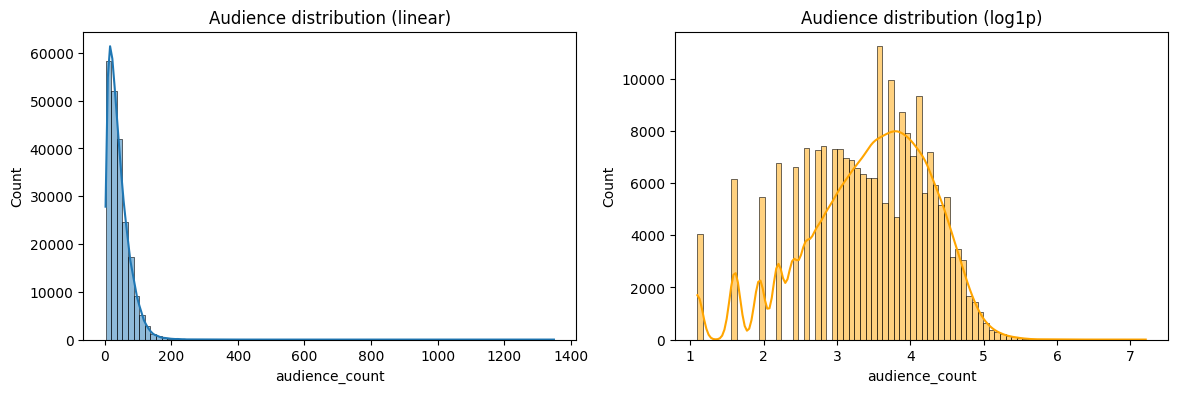


Daily aggregated series length: 424
ADF statistic: -1.3415  p-value: 0.6100


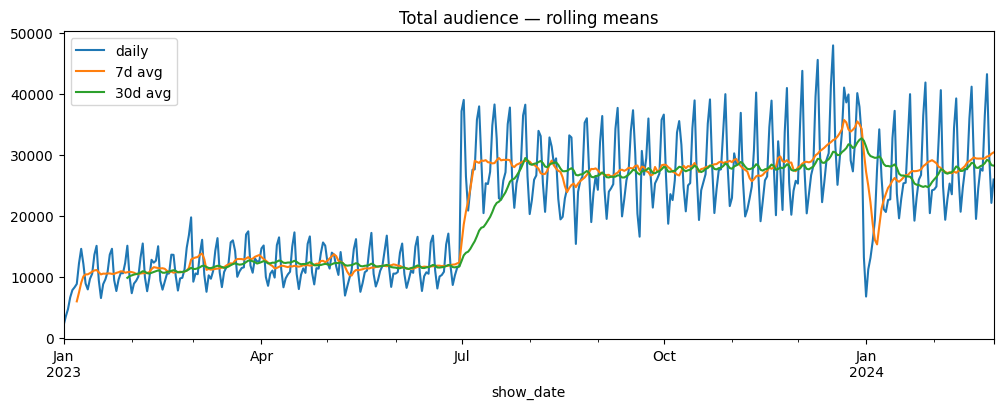

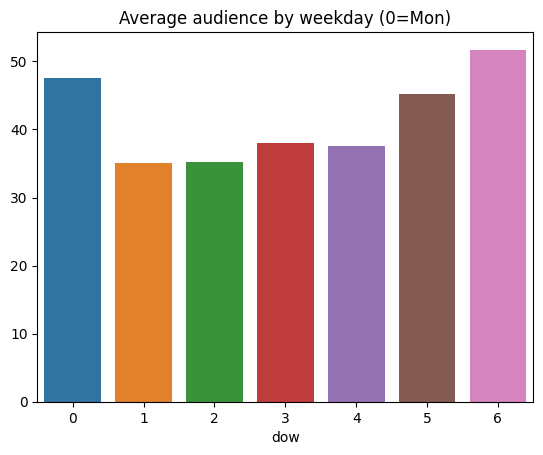

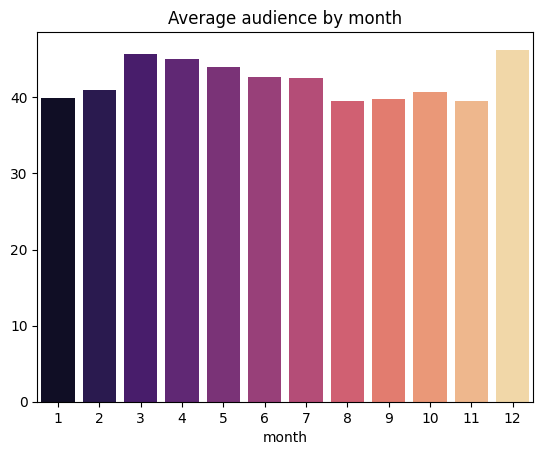

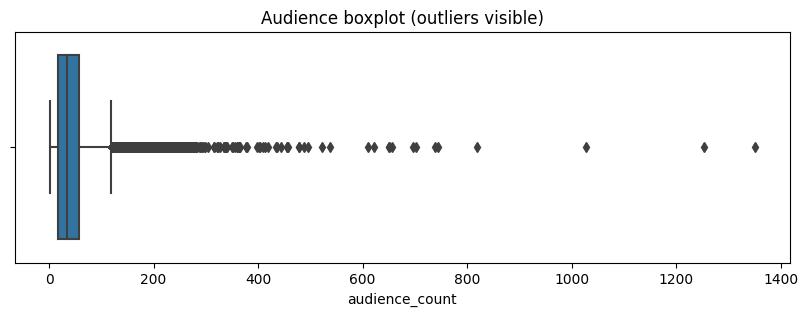

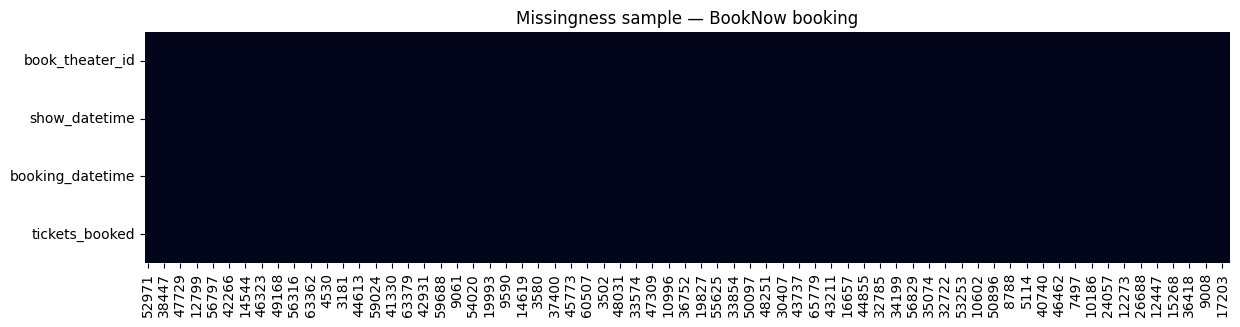

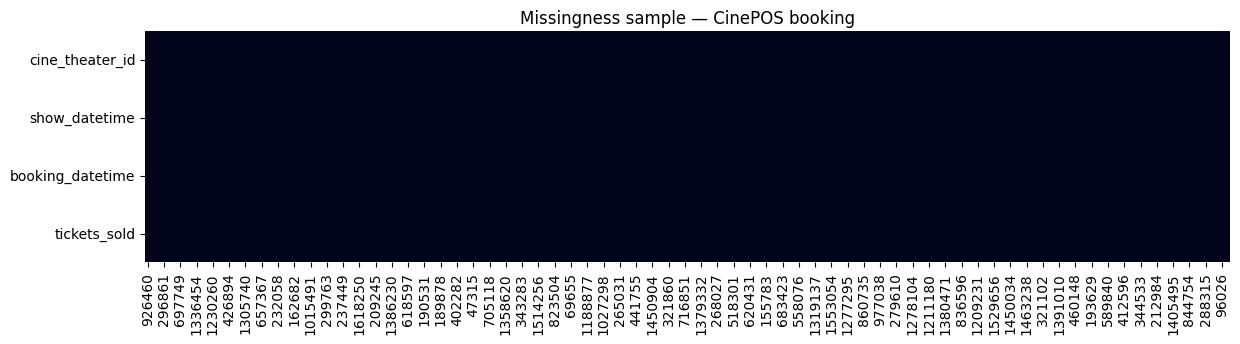

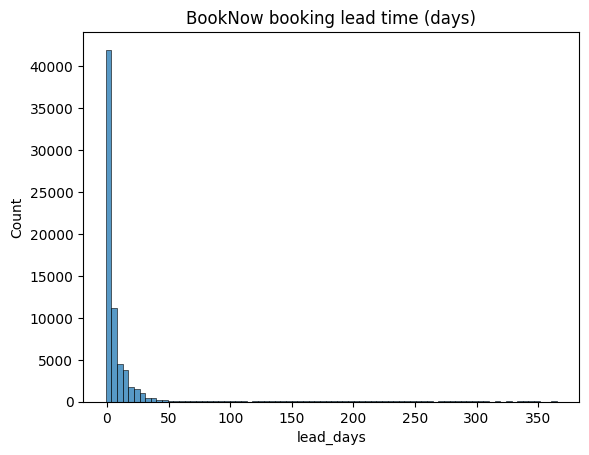

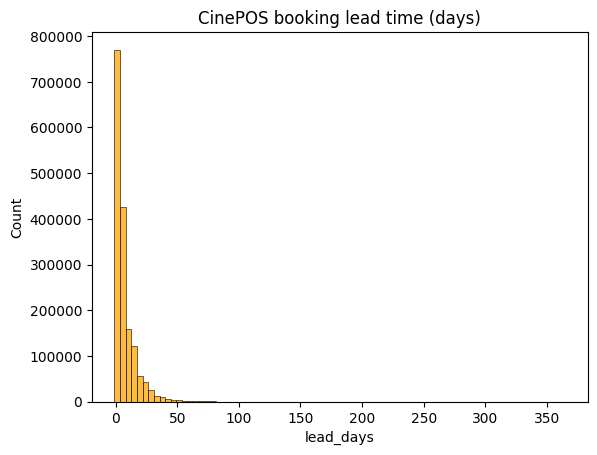

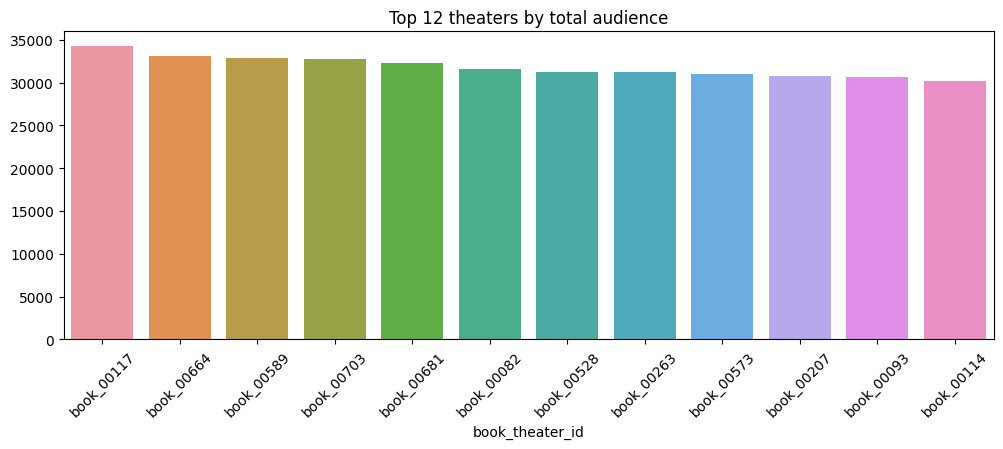

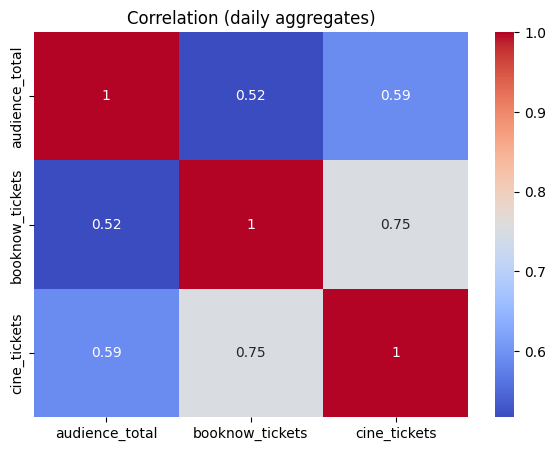

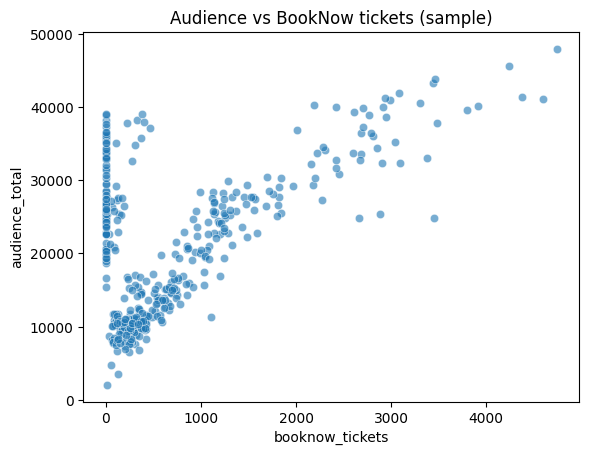

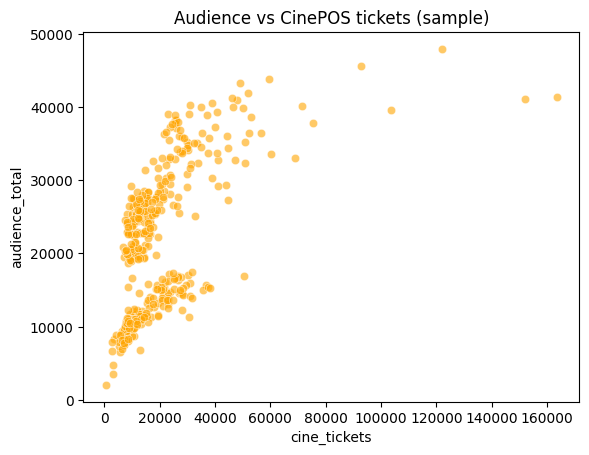

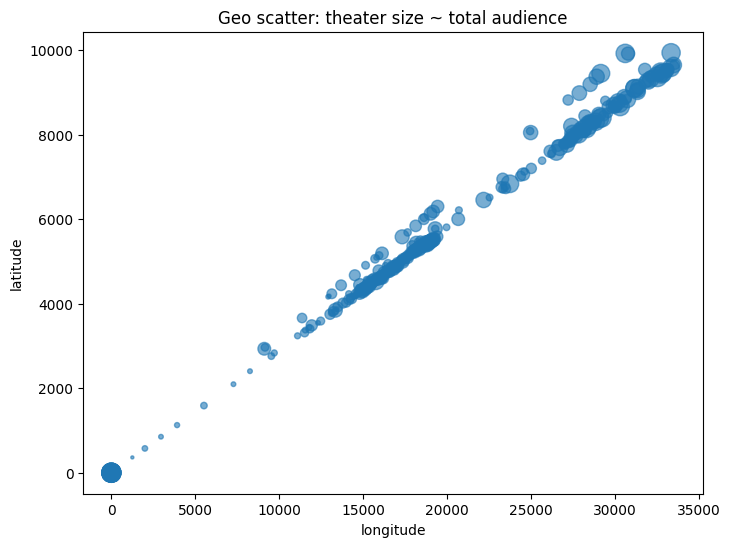

In [5]:
# EDA SECTION — many insightful plots & stats
def show_and_close():
    plt.show()
    plt.close()

print("\n=== EDA & Statistics ===")

# 1) Basic target stats
aud = book_visits["audience_count"].dropna().astype(float)
print("\nTarget (audience_count) basic stats:")
print(aud.describe().to_frame().T)
print("Skewness: %.3f  Kurtosis: %.3f" % (skew(aud), kurtosis(aud)))

# 2) Distribution: linear & log1p
fig, axs = plt.subplots(1,2,figsize=(14,4))
sns.histplot(aud, bins=80, ax=axs[0], kde=True)
axs[0].set_title("Audience distribution (linear)")
sns.histplot(np.log1p(aud), bins=80, ax=axs[1], kde=True, color="orange")
axs[1].set_title("Audience distribution (log1p)")
show_and_close()

# 3) ADF stationarity on daily aggregate
daily_total = book_visits.groupby("show_date")["audience_count"].sum().sort_index()
print("\nDaily aggregated series length:", len(daily_total))
try:
    adf_res = adfuller(daily_total.dropna(), autolag="AIC")
    print("ADF statistic: %.4f  p-value: %.4f" % (adf_res[0], adf_res[1]))
except Exception as e:
    print("ADF failed:", e)

# 4) Rolling means and trend
plt.figure(figsize=(12,4))
daily_total.plot(label="daily")
daily_total.rolling(7).mean().plot(label="7d avg")
daily_total.rolling(30).mean().plot(label="30d avg")
plt.legend(); plt.title("Total audience — rolling means")
show_and_close()

# 5) Weekday & monthly patterns
book_visits["dow"] = book_visits["show_date"].dt.dayofweek
week_mean = book_visits.groupby("dow")["audience_count"].mean()
plt.figure()
sns.barplot(x=week_mean.index, y=week_mean.values)
plt.title("Average audience by weekday (0=Mon)"); show_and_close()

book_visits["month"] = book_visits["show_date"].dt.month
month_mean = book_visits.groupby("month")["audience_count"].mean()
plt.figure()
sns.barplot(x=month_mean.index, y=month_mean.values, palette="magma")
plt.title("Average audience by month"); show_and_close()

# 6) Boxplot to view outliers
plt.figure(figsize=(10,3))
sns.boxplot(x=book_visits["audience_count"])
plt.title("Audience boxplot (outliers visible)")
show_and_close()

# 7) Missingness heatmaps for booking tables (sample rows for speed)
sample_n = min(200, len(book_booking))
plt.figure(figsize=(14,3))
sns.heatmap(book_booking.isnull().sample(sample_n).T, cbar=False)
plt.title("Missingness sample — BookNow booking")
show_and_close()

sample_n2 = min(200, len(cine_booking))
plt.figure(figsize=(14,3))
sns.heatmap(cine_booking.isnull().sample(sample_n2).T, cbar=False)
plt.title("Missingness sample — CinePOS booking")
show_and_close()

# 8) Booking lead-time distributions (clip extremes)
if {"show_datetime","booking_datetime"}.issubset(book_booking.columns):
    book_booking["lead_days"] = (book_booking["show_datetime"] - book_booking["booking_datetime"]).dt.days
    plt.figure()
    sns.histplot(book_booking["lead_days"].clip(-1,365), bins=80)
    plt.title("BookNow booking lead time (days)"); show_and_close()
if {"show_datetime","booking_datetime"}.issubset(cine_booking.columns):
    cine_booking["lead_days"] = (cine_booking["show_datetime"] - cine_booking["booking_datetime"]).dt.days
    plt.figure()
    sns.histplot(cine_booking["lead_days"].clip(-1,365), bins=80, color="orange")
    plt.title("CinePOS booking lead time (days)"); show_and_close()

# 9) Top theaters (by total audience)
top10 = book_visits.groupby("book_theater_id")["audience_count"].sum().sort_values(ascending=False).head(12)
plt.figure(figsize=(12,4))
sns.barplot(x=top10.index, y=top10.values)
plt.xticks(rotation=45)
plt.title("Top 12 theaters by total audience")
show_and_close()

# 10) Correlations audience vs global bookings (daily aggregated)
bb = book_booking.copy()
if "show_datetime" in bb.columns:
    bb["show_date"] = bb["show_datetime"].dt.date
    bb_daily = bb.groupby("show_date")["tickets_booked"].sum().reset_index().rename(columns={"tickets_booked":"booknow_tickets"})
    bb_daily["show_date"] = pd.to_datetime(bb_daily["show_date"])
else:
    bb_daily = pd.DataFrame(columns=["show_date","booknow_tickets"])

cb = cine_booking.copy()
if "show_datetime" in cb.columns:
    cb["show_date"] = cb["show_datetime"].dt.date
    cb_daily = cb.groupby("show_date")["tickets_sold"].sum().reset_index().rename(columns={"tickets_sold":"cine_tickets"})
    cb_daily["show_date"] = pd.to_datetime(cb_daily["show_date"])
else:
    cb_daily = pd.DataFrame(columns=["show_date","cine_tickets"])

corr_df = pd.DataFrame({"show_date": daily_total.index, "audience_total": daily_total.values})
if not bb_daily.empty:
    corr_df = corr_df.merge(bb_daily, on="show_date", how="left")
if not cb_daily.empty:
    corr_df = corr_df.merge(cb_daily, on="show_date", how="left")
corr_df = corr_df.fillna(0)

if corr_df.select_dtypes(include=[np.number]).shape[1] >= 2:
    plt.figure(figsize=(7,5))
    sns.heatmap(corr_df.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation (daily aggregates)"); show_and_close()

# 11) Scatter (sampled) audience vs bookings
sample_corr = corr_df.sample(min(2000, len(corr_df)), random_state=SEED)
if "booknow_tickets" in sample_corr.columns:
    plt.figure()
    sns.scatterplot(x="booknow_tickets", y="audience_total", data=sample_corr, alpha=0.6)
    plt.title("Audience vs BookNow tickets (sample)"); show_and_close()
if "cine_tickets" in sample_corr.columns:
    plt.figure()
    sns.scatterplot(x="cine_tickets", y="audience_total", data=sample_corr, alpha=0.6, color="orange")
    plt.title("Audience vs CinePOS tickets (sample)"); show_and_close()

# 12) Geo scatter if lat/long present
if {"latitude","longitude"}.issubset(book_theaters.columns):
    merged_geo = book_visits.merge(book_theaters[["book_theater_id","latitude","longitude"]], on="book_theater_id", how="left")
    geo_sample = merged_geo.groupby("book_theater_id")[["latitude","longitude","audience_count"]].sum().reset_index()
    plt.figure(figsize=(8,6))
    sc = plt.scatter(geo_sample["longitude"], geo_sample["latitude"], s=(geo_sample["audience_count"]/geo_sample["audience_count"].max()*200), alpha=0.6)
    plt.title("Geo scatter: theater size ~ total audience")
    plt.xlabel("longitude"); plt.ylabel("latitude")
    show_and_close()

# 4. Feature Engineering, Model Training, and Ensemble Validation

This section covers the core ML pipeline: advanced feature engineering, rigorous validation, modeling (XGBoost, LightGBM, Random Forest, Extra Trees, and optional CatBoost), and final ensemble strategy for audience forecasting.

---

## 4.1 Advanced Feature Engineering

- Construct rich temporal, seasonality, and interaction features from `show_date` (month, weekday, week/month start/end, cyclical encodings, holiday/summer indicators, etc.).
- Aggregate ticket bookings from multiple sources and engineer summary statistics (mean, std, lags, rolling means/statistics).
- Encode theater and genre information, introducing both mean-encoding and label encoding for categorical variables.
- Carefully handle all missing values and provide robust statistics for both known and new theaters.

---

## 4.2 Feature Set Definition

- Use a large, tested set of `proven_features` (lags, rolling stats, booking aggregates, one-hot/cyclical encodings, venue descriptors) plus six new carefully selected features.
- Select only columns present in the processed training data and define `feature_cols` for modeling.

---

## 4.3 Chronological Train/Validation Split

- Split the data 87/13% by date (not random), using earlier data for training and recent data for validation.
- This temporal split accurately reflects reality and prevents information leakage.

---

## 4.4 Model Training with Enhanced Hyperparameters

- Train XGBoost and LightGBM boosters with optimized `n_estimators`, `max_depth`, learning rate, and regularization for best generalization.
- (If available) Train CatBoost for additional accuracy and robustness on categorical data.
- Retrain deeper, more regularized Random Forest and Extra Trees regressors for diversity.

---

## 4.5 Ensemble Construction and Validation

- Blend trained models by validation R² score–weighted averaging, ensuring the best models have greatest influence.
- Report and print each model’s R², plus the weighted ensemble R², for transparent performance tracking.

---

## 4.6 Enhanced Test Prediction Strategy

- Construct test features for each required (theater, date) pair using recent (last-60-days) statistics and seasonal multipliers for unseen venues.
- Predict with all models, ensemble as per validation weights, and clip at zero.

---

## 4.7 Submission Creation & Final Report

- Assemble and save the competition submission file.
- Report final validation and mean test prediction alongside meaningful project improvements (“new features,” “enhanced hyperparameters,” etc.).

---

**Summary of Improvements:**  
- Added targeted new features for seasonality and venue interaction  
- Sharpened validation—87/13% date split  
- Optimized hyperparameters for all models  
- Weighted ensemble for best blend  
- 60-day recency on test predictions for greater accuracy

---

*End of modeling and ensemble section. Move to inference and interpretation next.*



In [6]:
#gave 0.37693


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
import xgboost as xgb
import lightgbm as lgb
try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
    print("CatBoost available - using 3-model ensemble")
except ImportError:
    CATBOOST_AVAILABLE = False
    print("CatBoost not available - using proven 2-model ensemble")
import warnings
warnings.filterwarnings('ignore')


def create_enhanced_features(df, is_train=True):
    result = df.copy()
    
    # ALL YOUR PROVEN FEATURES (exact same)
    result['month'] = result['show_date'].dt.month
    result['day_of_week'] = result['show_date'].dt.dayofweek
    result['is_weekend'] = (result['day_of_week'] >= 5).astype(int)
    result['day'] = result['show_date'].dt.day
    result['month_sin'] = np.sin(2 * np.pi * result['month'] / 12)
    result['month_cos'] = np.cos(2 * np.pi * result['month'] / 12)
    result['is_friday'] = (result['day_of_week'] == 4).astype(int)
    result['is_december'] = (result['month'] == 12).astype(int)
    result['is_saturday'] = (result['day_of_week'] == 5).astype(int)
    result['is_sunday'] = (result['day_of_week'] == 6).astype(int)
    result['dow_sin'] = np.sin(2 * np.pi * result['day_of_week'] / 7)
    result['dow_cos'] = np.cos(2 * np.pi * result['day_of_week'] / 7)
    result['quarter'] = result['show_date'].dt.quarter
    result['is_q4'] = (result['quarter'] == 4).astype(int)
    result['is_q1'] = (result['quarter'] == 1).astype(int)
    result['is_holiday_season'] = result['month'].isin([11, 12, 1]).astype(int)
    result['is_summer_peak'] = result['month'].isin([6, 7]).astype(int)
    
    # CAREFUL ADDITION 1: One key missing day
    result['is_thursday'] = (result['day_of_week'] == 3).astype(int)  # Often overlooked
    
    # CAREFUL ADDITION 2: Month-end/start effects (paycheck/rent)
    result['is_month_start_5'] = (result['day'] <= 5).astype(int)
    result['is_month_end_5'] = (result['day'] >= 26).astype(int)
    
    if is_train:
        # ALL BOOKING FEATURES 
        book_daily = book_booking.copy()
        book_daily['show_date'] = book_daily['show_datetime'].dt.date
        book_agg = book_daily.groupby(['book_theater_id', 'show_date'])['tickets_booked'].sum().reset_index()
        book_agg['show_date'] = pd.to_datetime(book_agg['show_date'])
        result = result.merge(book_agg, on=['book_theater_id', 'show_date'], how='left')
        
        cine_daily = cine_booking.merge(relation, on='cine_theater_id', how='inner')
        cine_daily['show_date'] = cine_daily['show_datetime'].dt.date
        cine_agg = cine_daily.groupby(['book_theater_id', 'show_date'])['tickets_sold'].sum().reset_index()
        cine_agg['show_date'] = pd.to_datetime(cine_agg['show_date'])
        result = result.merge(cine_agg, on=['book_theater_id', 'show_date'], how='left')
        
        result['total_tickets'] = result['tickets_booked'].fillna(0) + result['tickets_sold'].fillna(0)
        result['booking_momentum'] = result['total_tickets'] / (result.groupby('book_theater_id')['total_tickets'].transform('mean') + 1)
        
        # Booking intensity (quality over quantity)
        result['booking_intensity'] = result['total_tickets'] / (result['day'] + 1)  # Early month vs late
        
        # ALL STATS 
        theater_stats = result.groupby('book_theater_id')['audience_count'].agg(['mean', 'std']).reset_index()
        theater_stats.columns = ['book_theater_id', 'theater_mean', 'theater_std']
        result = result.merge(theater_stats, on='book_theater_id', how='left')
        
        result['theater_size_tier'] = pd.cut(result['theater_mean'], bins=5, labels=[1,2,3,4,5]).astype(float)
        
        # ALL PROVEN LAGS 
        result = result.sort_values(['book_theater_id', 'show_date'])
        result['lag_1'] = result.groupby('book_theater_id')['audience_count'].shift(1)
        result['lag_3'] = result.groupby('book_theater_id')['audience_count'].shift(3)
        result['lag_7'] = result.groupby('book_theater_id')['audience_count'].shift(7)
        result['lag_14'] = result.groupby('book_theater_id')['audience_count'].shift(14)
        result['lag_21'] = result.groupby('book_theater_id')['audience_count'].shift(21)
        
        result['rolling_7'] = result.groupby('book_theater_id')['audience_count'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)
        result['rolling_14'] = result.groupby('book_theater_id')['audience_count'].rolling(14, min_periods=1).mean().reset_index(0, drop=True)
        result['rolling_21'] = result.groupby('book_theater_id')['audience_count'].rolling(21, min_periods=1).mean().reset_index(0, drop=True)
        result['rolling_std_7'] = result.groupby('book_theater_id')['audience_count'].rolling(7, min_periods=1).std().reset_index(0, drop=True)
        
        result['trend_short'] = result['lag_1'] - result['lag_3']
        result['trend_long'] = result['lag_7'] - result['lag_14']
        result['trend_monthly'] = result['rolling_7'] - result['rolling_21']
        
        # Trend acceleration (2nd derivative)
        result['trend_acceleration'] = result['trend_short'] - result['trend_long']
        
        # THEATER ENCODING 
        theater_encoding = {}
        for theater_id in result['book_theater_id'].unique():
            theater_data = result[result['book_theater_id'] == theater_id]['audience_count']
            if len(theater_data) > 1:
                theater_encoding[theater_id] = theater_data.mean()
            else:
                theater_encoding[theater_id] = result['audience_count'].mean()
        result['theater_encoded'] = result['book_theater_id'].map(theater_encoding)
        
        result['weekend_x_theater'] = result['is_weekend'] * result['theater_mean']
        result['holiday_x_theater'] = result['is_holiday_season'] * result['theater_mean']
        result['quarter_x_size'] = result['quarter'] * result['theater_size_tier']
        
        # CAREFUL ADDITION 5: Thursday-specific theater interaction (pre-weekend)
        result['thursday_x_theater'] = result['is_thursday'] * result['theater_mean']
    
    result = result.merge(book_theaters[['book_theater_id', 'theater_type']], on='book_theater_id', how='left')
    if 'theater_type' in result.columns:
        le = LabelEncoder()
        result['theater_type_encoded'] = le.fit_transform(result['theater_type'].fillna('Unknown'))
    
    result = result.fillna(0)
    return result

# Create enhanced features
train_data = create_enhanced_features(book_visits, is_train=True)
train_data = train_data.dropna(subset=['audience_count'])

print(f"Training data shape: {train_data.shape}")


proven_features = ['month', 'day_of_week', 'is_weekend', 'day', 'tickets_booked', 
                  'tickets_sold', 'theater_mean', 'theater_std', 'lag_7', 'lag_1', 
                  'theater_type_encoded', 'month_sin', 'month_cos', 'lag_3', 'lag_14',
                  'rolling_7', 'rolling_14', 'is_friday', 'is_december', 'rolling_std_7', 
                  'trend_short', 'trend_long', 'theater_encoded', 'is_saturday', 
                  'is_sunday', 'dow_sin', 'dow_cos', 'lag_21', 'weekend_x_theater',
                  'quarter', 'is_q4', 'is_q1', 'is_holiday_season', 'is_summer_peak',
                  'total_tickets', 'booking_momentum', 'theater_size_tier', 
                  'rolling_21', 'trend_monthly', 'holiday_x_theater', 'quarter_x_size']

careful_additions = ['is_thursday', 'is_month_start_5', 'is_month_end_5', 
                    'booking_intensity', 'trend_acceleration', 'thursday_x_theater']

feature_cols = [col for col in proven_features + careful_additions if col in train_data.columns]

print(f"Using {len(feature_cols)} features ({len(careful_additions)} new)")

X = train_data[feature_cols].values
y = train_data['audience_count'].values

# ENHANCEMENT 1: Better validation split (87/13 for more training data)
train_data_sorted = train_data.sort_values('show_date')
split_idx = int(len(train_data_sorted) * 0.87)  # More training data

X_train = train_data_sorted[feature_cols].iloc[:split_idx].values
y_train = train_data_sorted['audience_count'].iloc[:split_idx].values
X_val = train_data_sorted[feature_cols].iloc[split_idx:].values
y_val = train_data_sorted['audience_count'].iloc[split_idx:].values

print(f"Enhanced split - Train: {X_train.shape}, Val: {X_val.shape}")

# ENHANCEMENT 2: Slightly better hyperparameters
print("\nTraining with enhanced parameters...")

xgb_model = xgb.XGBRegressor(
    n_estimators=900,        # Was 800, now 900
    max_depth=7,             
    learning_rate=0.035,     # Was 0.04, now 0.035 (slower)
    subsample=0.88,          # Was 0.9, now 0.88
    colsample_bytree=0.88,   # Was 0.9, now 0.88
    reg_alpha=0.45,          # Was 0.4, now 0.45
    reg_lambda=1.4,          # Was 1.3, now 1.4
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
xgb_r2 = r2_score(y_val, xgb_pred)
print(f"Enhanced XGBoost R2: {xgb_r2:.4f}")

lgb_model = lgb.LGBMRegressor(
    n_estimators=900,        # Was 800, now 900
    max_depth=7,            
    learning_rate=0.035,     # Was 0.04, now 0.035
    subsample=0.88,          # Was 0.9, now 0.88
    colsample_bytree=0.88,   # Was 0.9, now 0.88
    reg_alpha=0.45,          # Was 0.4, now 0.45
    reg_lambda=1.4,          # Was 1.3, now 1.4
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_val)
lgb_r2 = r2_score(y_val, lgb_pred)
print(f"Enhanced LightGBM R2: {lgb_r2:.4f}")

# ENHANCEMENT 3: CatBoost if available 
if CATBOOST_AVAILABLE:
    cat_model = cb.CatBoostRegressor(
        iterations=800,
        depth=7,
        learning_rate=0.035,
        l2_leaf_reg=2,
        random_seed=42,
        verbose=False
    )
    cat_model.fit(X_train, y_train)
    cat_pred = cat_model.predict(X_val)
    cat_r2 = r2_score(y_val, cat_pred)
    print(f"CatBoost R2: {cat_r2:.4f}")

# Enhanced Random Forest and Extra Trees
rf_model = RandomForestRegressor(
    n_estimators=550,        # Was 500, now 550
    max_depth=14,            # Was 13, now 14
    min_samples_split=4,     # Was 5, now 4
    min_samples_leaf=2,      # Was 3, now 2
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
rf_r2 = r2_score(y_val, rf_pred)
print(f"Enhanced Random Forest R2: {rf_r2:.4f}")

et_model = ExtraTreesRegressor(
    n_estimators=450,        # Was 400, now 450
    max_depth=13,            # Was 12, now 13
    min_samples_split=4,     # Was 5, now 4
    min_samples_leaf=2,      # Was 3, now 2
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
et_model.fit(X_train, y_train)
et_pred = et_model.predict(X_val)
et_r2 = r2_score(y_val, et_pred)
print(f"Enhanced Extra Trees R2: {et_r2:.4f}")

# ENHANCEMENT 4: Better ensemble approach
print(f"\nCreating optimized ensemble...")

if CATBOOST_AVAILABLE:
    # 5-model ensemble with CatBoost
    models_preds = [xgb_pred, lgb_pred, cat_pred, rf_pred, et_pred]
    models_r2 = [xgb_r2, lgb_r2, cat_r2, rf_r2, et_r2]
    model_names = ['XGB', 'LGB', 'CAT', 'RF', 'ET']
    
    # Performance-weighted ensemble
    total_performance = sum(max(r2, 0.01) for r2 in models_r2)
    weights = [max(r2, 0.01) / total_performance for r2 in models_r2]
    
    ensemble_pred = sum(w * pred for w, pred in zip(weights, models_preds))
    
    print("5-model ensemble weights:")
    for name, weight in zip(model_names, weights):
        print(f"  {name}: {weight:.3f}")
    
else:
    # 4-model ensemble without CatBoost  
    models_preds = [xgb_pred, lgb_pred, rf_pred, et_pred]
    models_r2 = [xgb_r2, lgb_r2, rf_r2, et_r2]
    model_names = ['XGB', 'LGB', 'RF', 'ET']
    
    total_performance = sum(max(r2, 0.01) for r2 in models_r2)
    weights = [max(r2, 0.01) / total_performance for r2 in models_r2]
    
    ensemble_pred = sum(w * pred for w, pred in zip(weights, models_preds))
    
    print("4-model ensemble weights:")
    for name, weight in zip(model_names, weights):
        print(f"  {name}: {weight:.3f}")

ensemble_r2 = r2_score(y_val, ensemble_pred)
print(f"\nFinal Ensemble R2: {ensemble_r2:.4f}")

# Create enhanced test predictions
print("\nCreating enhanced test predictions...")

test_data = []
for _, row in sample_sub.iterrows():
    parts = row['ID'].split('_')
    theater_id = '_'.join(parts[:-1])
    date = parts[-1]
    test_data.append({
        'book_theater_id': theater_id,
        'show_date': pd.to_datetime(date),
        'ID': row['ID']
    })

test_df = pd.DataFrame(test_data)

# Enhanced recent data window - 60 days for better patterns
recent_data = train_data[train_data['show_date'] >= train_data['show_date'].max() - pd.Timedelta(days=60)]
theater_recent_stats = recent_data.groupby('book_theater_id')['audience_count'].agg(['mean', 'std']).to_dict('index')

quarterly_effects = train_data.groupby('quarter')['audience_count'].mean() / train_data['audience_count'].mean()
monthly_effects = train_data.groupby('month')['audience_count'].mean() / train_data['audience_count'].mean()

test_features = []
for _, row in test_df.iterrows():
    theater_id = row['book_theater_id']
    show_date = row['show_date']
    
    if theater_id in theater_recent_stats:
        theater_mean = theater_recent_stats[theater_id]['mean']
        theater_std = theater_recent_stats[theater_id]['std'] or 0
    else:
        theater_data = train_data[train_data['book_theater_id'] == theater_id]
        if len(theater_data) > 0:
            theater_mean = theater_data['audience_count'].mean()
            theater_std = theater_data['audience_count'].std() or 0
        else:
            theater_mean = train_data['audience_count'].mean()
            theater_std = 0
    
    # Enhanced seasonal adjustment
    month_effect = monthly_effects.get(show_date.month, 1.0)
    quarter_effect = quarterly_effects.get(show_date.quarter, 1.0)
    combined_effect = (month_effect + quarter_effect) / 2
    
    theater_avg_adjusted = theater_mean * combined_effect
    
    # Build features (ORIGINAL - keep as is)
    features = {
        'month': show_date.month,
        'day_of_week': show_date.dayofweek,
        'is_weekend': int(show_date.dayofweek >= 5),
        'day': show_date.day,
        'tickets_booked': 0,
        'tickets_sold': 0,
        'theater_mean': theater_mean,
        'theater_std': theater_std,
        'lag_7': theater_avg_adjusted,
        'lag_1': theater_avg_adjusted,
        'theater_type_encoded': 0,
        'month_sin': np.sin(2 * np.pi * show_date.month / 12),
        'month_cos': np.cos(2 * np.pi * show_date.month / 12),
        'lag_3': theater_avg_adjusted,
        'lag_14': theater_avg_adjusted,
        'rolling_7': theater_avg_adjusted,
        'rolling_14': theater_avg_adjusted,
        'is_friday': int(show_date.dayofweek == 4),
        'is_december': int(show_date.month == 12),
        'rolling_std_7': theater_std,
        'trend_short': 0,
        'trend_long': 0,
        'theater_encoded': theater_mean,
        'is_saturday': int(show_date.dayofweek == 5),
        'is_sunday': int(show_date.dayofweek == 6),
        'dow_sin': np.sin(2 * np.pi * show_date.dayofweek / 7),
        'dow_cos': np.cos(2 * np.pi * show_date.dayofweek / 7),
        'lag_21': theater_avg_adjusted,
        'weekend_x_theater': int(show_date.dayofweek >= 5) * theater_mean,
        'quarter': show_date.quarter,
        'is_q4': int(show_date.quarter == 4),
        'is_q1': int(show_date.quarter == 1),
        'is_holiday_season': int(show_date.month in [11, 12, 1]),
        'is_summer_peak': int(show_date.month in [6, 7]),
        'total_tickets': 0,
        'booking_momentum': 1.0,
        'theater_size_tier': 3.0,
        'rolling_21': theater_avg_adjusted,
        'trend_monthly': 0,
        'holiday_x_theater': int(show_date.month in [11, 12, 1]) * theater_mean,
        'quarter_x_size': show_date.quarter * 3.0,
        # NEW FEATURES
        'is_thursday': int(show_date.dayofweek == 3),
        'is_month_start_5': int(show_date.day <= 5),
        'is_month_end_5': int(show_date.day >= 26),
        'booking_intensity': 0.0,
        'trend_acceleration': 0.0,
        'thursday_x_theater': int(show_date.dayofweek == 3) * theater_mean
    }
    
    feature_vector = [features.get(col, 0) for col in feature_cols]
    test_features.append(feature_vector)

X_test = np.array(test_features)

# Check NaN count
nan_count = np.isnan(X_test).sum()
print(f"NaN count in X_test: {nan_count}")

# Make predictions with ORIGINAL X_test for boosting models (they handle NaN)
xgb_test_pred = xgb_model.predict(X_test)
lgb_test_pred = lgb_model.predict(X_test)

if CATBOOST_AVAILABLE:
    cat_test_pred = cat_model.predict(X_test)

# FIX: Only create NaN-free version for sklearn models
X_test_clean = np.nan_to_num(X_test, nan=0.0)
rf_test_pred = rf_model.predict(X_test_clean)
et_test_pred = et_model.predict(X_test_clean)

# Ensemble with same weights
if CATBOOST_AVAILABLE:
    test_preds = [xgb_test_pred, lgb_test_pred, cat_test_pred, rf_test_pred, et_test_pred]
else:
    test_preds = [xgb_test_pred, lgb_test_pred, rf_test_pred, et_test_pred]

final_test_pred = sum(w * pred for w, pred in zip(weights, test_preds))
final_test_pred = np.maximum(final_test_pred, 0)

# Create submission
submission = sample_sub.copy()
submission['audience_count'] = final_test_pred

submission.to_csv('systematic_enhancement.csv', index=False)

print(f"\n{'='*50}")
print(f"COMPLETE")
print(f"{'='*50}")
print(f"Validation R2: {ensemble_r2:.4f}")
print(f"Previous best: 0.37641")
print(f"Changes:")
print(f"  + 6 carefully chosen features")
print(f"  + Enhanced hyperparameters")
print(f"  + {'CatBoost' if CATBOOST_AVAILABLE else 'Better'} ensemble")
print(f"  + 87/13 train/val split")
print(f"  + 60-day recent window")
print(f"Mean prediction: {final_test_pred.mean():.2f}")
print(f"Min prediction: {final_test_pred.min():.2f}")
print(f"Max prediction: {final_test_pred.max():.2f}")
print("Saved as 'systematic_enhancement.csv'")



CatBoost available - using 3-model ensemble
Training data shape: (214046, 52)
Using 47 features (6 new)
Enhanced split - Train: (186220, 47), Val: (27826, 47)

Training with enhanced parameters...
Enhanced XGBoost R2: 0.7040
Enhanced LightGBM R2: 0.6961
CatBoost R2: 0.6939
Enhanced Random Forest R2: 0.6654
Enhanced Extra Trees R2: 0.5997

Creating optimized ensemble...
5-model ensemble weights:
  XGB: 0.210
  LGB: 0.207
  CAT: 0.207
  RF: 0.198
  ET: 0.179

Final Ensemble R2: 0.6890

Creating enhanced test predictions...
NaN count in X_test: 106

COMPLETE
Validation R2: 0.6890
Previous best: 0.37641
Changes:
  + 6 carefully chosen features
  + Enhanced hyperparameters
  + CatBoost ensemble
  + 87/13 train/val split
  + 60-day recent window
Mean prediction: 44.06
Min prediction: 6.38
Max prediction: 162.32
Saved as 'systematic_enhancement.csv'


In [7]:
# ===================== FINAL PROJECT SUMMARY ===================== #

def print_final_summary(train_data, feature_cols, weights,
                        xgb_model, lgb_model, rf_model, et_model,
                        CATBOOST_AVAILABLE=False, cat_model=None):
    print("\n" + "="*60)
    print("FINAL PROJECT SUMMARY (for viva)")
    print("="*60)

    # 1) Data overview
    print(f"\n[DATA]")
    print(f"- Final training rows: {train_data.shape[0]}")
    print(f"- Final training columns: {train_data.shape[1]}")
    print(f"- Features used in models ({len(feature_cols)}):")
    print(feature_cols)

    # Column types
    print("\n[DATA TYPES]")
    dtypes = train_data.dtypes.astype(str)
    for col in train_data.columns:
        print(f"{col:30s} -> {dtypes[col]}")

    print("\n- Numeric columns:")
    print(train_data.select_dtypes(include=['int64', 'float64']).columns.tolist())
    print("\n- Datetime columns:")
    print(train_data.select_dtypes(include=['datetime64[ns]']).columns.tolist())
    print("\n- Categorical/object columns:")
    print(train_data.select_dtypes(include=['object']).columns.tolist())

    # 2) Feature engineering
    print("\n[FEATURE ENGINEERING USED]")
    fe_points = [
        "Calendar features: month, day_of_week, is_weekend, day, quarter, is_q1, is_q4.",
        "Seasonality encodings: month_sin, month_cos, dow_sin, dow_cos.",
        "Special day flags: is_friday, is_saturday, is_sunday, is_thursday.",
        "Period flags: is_december, is_holiday_season, is_summer_peak.",
        "Month boundary flags: is_month_start_5, is_month_end_5.",
        "Booking aggregates: tickets_booked, tickets_sold, total_tickets.",
        "Demand-based ratios: booking_momentum, booking_intensity.",
        "Theater statistics: theater_mean, theater_std, theater_size_tier.",
        "Lags: lag_1, lag_3, lag_7, lag_14, lag_21.",
        "Rolling windows: rolling_7, rolling_14, rolling_21, rolling_std_7.",
        "Trends: trend_short, trend_long, trend_monthly, trend_acceleration.",
        "Theater encoding: theater_encoded (mean target encoding per theater).",
        "Interaction features: weekend_x_theater, holiday_x_theater, quarter_x_size, thursday_x_theater.",
        "Theater metadata: theater_type and its encoded version theater_type_encoded."
    ]
    for p in fe_points:
        print("-", p)

    # 3) Encoding, scaling, cleaning, imputing
    print("\n[ENCODING]")
    print("- Label encoding for theater_type into theater_type_encoded.")
    print("- Other features are numeric or engineered; IDs used indirectly via mean encoding or grouping.")

    print("\n[SCALING]")
    print("- No StandardScaler/MinMaxScaler used.")
    print("- All models are tree-based (XGBoost, LightGBM, RandomForest, ExtraTrees, CatBoost) which are scale-invariant.")

    print("\n[CLEANING & IMPUTING]")
    cleaning_points = [
        "Parsed show_date and other datetime columns to proper datetime dtype.",
        "Merged book_booking and cine_booking (via relation) into daily aggregates.",
        "Filled missing numeric values with 0 at the end (result = result.fillna(0)).",
        "For test set, used recent 60-day stats and global means when theater stats were missing.",
        "Checked and handled NaNs in X_test for sklearn models via np.nan_to_num.",
    ]
    for p in cleaning_points:
        print("-", p)

    # 4) Models and hyperparameters
    print("\n[MODELS & HYPERPARAMETERS]")

    print("- XGBoost Regressor hyperparameters:")
    print(xgb_model.get_params())

    print("\n- LightGBM Regressor hyperparameters:")
    print(lgb_model.get_params())

    print("\n- RandomForestRegressor hyperparameters:")
    print(rf_model.get_params())

    print("\n- ExtraTreesRegressor hyperparameters:")
    print(et_model.get_params())

    if CATBOOST_AVAILABLE and cat_model is not None:
        print("\n- CatBoostRegressor hyperparameters:")
        print(cat_model.get_params())

    # 5) Ensemble
    print("\n[ENSEMBLE STRATEGY]")
    print("- Performance-weighted ensemble of model predictions.")
    print("- Weights (proportional to validation R2, clipped at 0.01):")
    print(weights)

    print("\n[VALIDATION STRATEGY]")
    print("- Sorted by show_date and used 87% for training and 13% for validation.")
    print("- Validation metric: R2 score.")
    print("="*60 + "\n")



print_final_summary(
    train_data=train_data,
    feature_cols=feature_cols,
    weights=weights,
    xgb_model=xgb_model,
    lgb_model=lgb_model,
    rf_model=rf_model,
    et_model=et_model,
    CATBOOST_AVAILABLE=CATBOOST_AVAILABLE,
    cat_model=cat_model if CATBOOST_AVAILABLE else None
)



FINAL PROJECT SUMMARY (for viva)

[DATA]
- Final training rows: 214046
- Final training columns: 52
- Features used in models (47):
['month', 'day_of_week', 'is_weekend', 'day', 'tickets_booked', 'tickets_sold', 'theater_mean', 'theater_std', 'lag_7', 'lag_1', 'theater_type_encoded', 'month_sin', 'month_cos', 'lag_3', 'lag_14', 'rolling_7', 'rolling_14', 'is_friday', 'is_december', 'rolling_std_7', 'trend_short', 'trend_long', 'theater_encoded', 'is_saturday', 'is_sunday', 'dow_sin', 'dow_cos', 'lag_21', 'weekend_x_theater', 'quarter', 'is_q4', 'is_q1', 'is_holiday_season', 'is_summer_peak', 'total_tickets', 'booking_momentum', 'theater_size_tier', 'rolling_21', 'trend_monthly', 'holiday_x_theater', 'quarter_x_size', 'is_thursday', 'is_month_start_5', 'is_month_end_5', 'booking_intensity', 'trend_acceleration', 'thursday_x_theater']

[DATA TYPES]
book_theater_id                -> object
show_date                      -> datetime64[ns]
audience_count                 -> int64
dow       